In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [8]:
with open('song_df_aggregate.pkl', 'rb') as f:
        song_df= pickle.load(f)  

In [9]:
song_df["top10"] = song_df["bestrank"] <50

In [10]:
to_pop =["artist","title","isnew","rank","date","spotify_id","spotify_explicit",
             "spotify_album_id","spotify_album_release_date","spotify_album_release_date_precision","album_label",
             "join","spotify_album_release_date_datetime","numberofappearances","spotify_disc_number"]
#"spotify_mode","spotify_time_signature","num_artists","artist_has_award","gold_count","platinum_count","spotify_track_number"
[song_df.pop(i) for i in to_pop]
song_df.pop("last_award_type")
song_df.pop("spotify_key")
song_df.pop("bestrank")

0         1
1         2
2         1
3         1
4         1
       ... 
8514     79
8515     93
8516     95
8517     99
8518    100
Name: bestrank, Length: 8519, dtype: int64

In [11]:
song_df.pop("artist_has_award")
song_df = song_df.dropna()
top10 = song_df.pop("top10")


In [12]:
X_train, X_test, y_train, y_test = train_test_split(song_df, top10, test_size=0.2)

In [13]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


#can replace 'is_unbalance': 'true', by 'scale_pos_weight': 10,

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_train,
                       num_boost_round=100,
                       early_stopping_rounds=100)

predictions = model.predict(X_test)


[1]	training's auc: 0.939625
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 1
[3]	training's auc: 0.99997
[4]	training's auc: 0.999212
[5]	training's auc: 1
[6]	training's auc: 1
[7]	training's auc: 0.999999
[8]	training's auc: 1
[9]	training's auc: 1
[10]	training's auc: 1
[11]	training's auc: 1
[12]	training's auc: 1
[13]	training's auc: 1
[14]	training's auc: 1
[15]	training's auc: 1
[16]	training's auc: 1
[17]	training's auc: 1
[18]	training's auc: 1
[19]	training's auc: 1
[20]	training's auc: 1
[21]	training's auc: 1
[22]	training's auc: 1
[23]	training's auc: 1
[24]	training's auc: 1
[25]	training's auc: 1
[26]	training's auc: 1
[27]	training's auc: 1
[28]	training's auc: 1
[29]	training's auc: 1
[30]	training's auc: 1
[31]	training's auc: 1
[32]	training's auc: 1
[33]	training's auc: 1
[34]	training's auc: 1
[35]	training's auc: 1
[36]	training's auc: 1
[37]	training's auc: 1
[38]	training's auc: 1
[39]	training's auc: 1
[40]	training's auc: 1


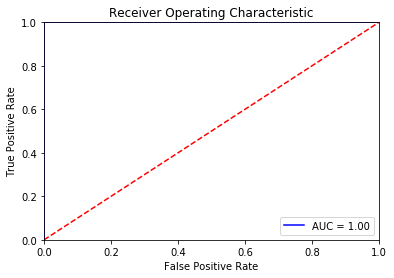

In [14]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
# Record the feature importances
feature_importances = model.feature_importance()
for i in range(len(feature_importances)):
    print(feature_importances[i],X_train.columns[i])

8 spotify_duration_ms
0 spotify_track_number
0 spotify_danceability
6 spotify_energy
0 spotify_loudness
0 spotify_mode
7 spotify_speechiness
1 spotify_acousticness
5 spotify_instrumentalness
1 spotify_liveness
4 spotify_valence
0 spotify_tempo
0 spotify_time_signature
0 num_artists
1 award_num
0 gold_count
0 platinum_count
0 num_songs_awards
11 firstrank
1 top50
2 top25
1 top75
0 top5


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


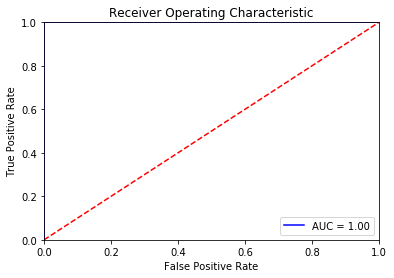

In [18]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.5 else 0 for pred in predictions]
confusion_matrix(y_test,predictions_matrix)

array([[752,  63],
       [  0, 839]])